In [8]:
import pandas as pd
import numpy as np
import re

In [77]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [78]:
dem = pd.read_csv('/Users/feihuyan/dem_tweets')
rep = pd.read_csv('/Users/feihuyan/gop_tweets')

In [79]:
df = pd.concat([dem, rep])

In [81]:
df.shape

(91525, 4)

In [86]:
def text(text):
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)','',text)
    text = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)','',text)
    text = re.sub(r'\-', ' ', text)
    text = re.sub(r'\B\@\w+.*','',text)
    text = re.sub(r'[cC][oO][vV].*','coronavirus',text)
    text = re.sub(r'&', 'and', text)
    text = re.sub(r'w\/', 'with', text)
    text = re.sub(r'[^A-Za-z|\s]','',text)
    text = text.lower()
    return text

In [87]:
df['text'] = df['text'].astype(str).apply(lambda x: text(x))

In [164]:
train_df = df.sample(frac=1)
train_df.head(10)

,Unnamed: 0,senator,text,target
18592,8184,SenatorRounds,our budget process is clearly broken thank you,1.0
36956,6275,senrobportman,groups like,1.0
8330,8330,SenatorBaldwin,couldnt agree more thats why im fighting for the next,0.0
20716,10308,SenatorEnzi,we should be supporting innovation in the energy industry rather than implementing overly burdensome rules that could increase energy costs and put people out of work,1.0
20068,2502,SenWarren,the federal government already contracts to produce vaccines and drugs for national emergencies by publicly manufacturing generic drugs my plan would lower skyrocketing drug prices increase competition in the generic drug market help address urgent medicine shortages,0.0
44300,4094,RoyBlunt,i met with my friend andy puzder today his strong leadership and critical thinking will serve the department of labor well,1.0
16079,5671,SteveDaines,historic day for the little shell tribe and mt federal recognition is finally heading to,1.0
1399,1399,ChrisCoons,with the senate passing save our seas and our recent commitment to the global ghost gear initiative the is making progress in tackling the global ocean plastic crisis however there is still much more to be done,0.0
14019,3611,JerryMoran,great to be with attendees of,1.0
2234,2234,SenMarkey,we are simply not doing enough to protect our seniors or workers in assisted living homes from,0.0


In [95]:
train_df = train_df[train_df['text'].apply(len) > 20]

In [96]:
train_df.shape

(77674, 4)

In [103]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [108]:
max_features = 30000
maxlen = 25
embedding_size = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['text']))
X = tokenizer.texts_to_sequences(list(train_df['text']))
X = pad_sequences(X, maxlen = maxlen)
y = train_df['target']

In [109]:
EMBEDDING_FILE = '/Users/feihuyan/Downloads/glove.twitter.27B.200d.txt'
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [114]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size, weights=[embedding_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                                      recurrent_dropout=0.5,
                                                      return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         6000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         336896    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                10280     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)               

In [115]:
batch_size = 100
epochs = 4
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/4
622/622 [==============================] - 97s 156ms/step - loss: 0.6170 - accuracy: 0.6493 - val_loss: 0.4767 - val_accuracy: 0.7587
Epoch 2/4
622/622 [==============================] - 101s 163ms/step - loss: 0.4524 - accuracy: 0.7919 - val_loss: 0.4292 - val_accuracy: 0.7896
Epoch 3/4
622/622 [==============================] - 105s 169ms/step - loss: 0.3669 - accuracy: 0.8393 - val_loss: 0.4411 - val_accuracy: 0.7948
Epoch 4/4
622/622 [==============================] - 99s 160ms/step - loss: 0.3133 - accuracy: 0.8663 - val_loss: 0.4721 - val_accuracy: 0.7891


In [116]:
import GetOldTweets3 as got
from tqdm import tqdm

In [117]:
def get_tweet(senators, df, affiliation, num_tweet, begin_date, end_date):
    for senator in tqdm(senators):
        tweetCriteria = got.manager.TweetCriteria().setUsername(senator).setSince(begin_date).setUntil(end_date).setMaxTweets(num_tweet)
        tweets = got.manager.TweetManager.getTweets(tweetCriteria)
        for tweet in tweets:
            dft = pd.DataFrame({'senator': senator,
                               'text': tweet.text,
                               'target': affiliation},index=[0])
            df = df.append(dft, ignore_index=True)
    return df

In [135]:
def test_model(senator, num_tweet, begin_date, end_date, maxlen, model):
    empty = pd.DataFrame({'senator': [],
                          'text': [],
                          'target': []}) 
    tweet = get_tweet(senator, empty, 0, num_tweet, begin_date, end_date)
    tweet['text'] = tweet['text'].astype(str).apply(lambda x: text(x))
    X = tokenizer.texts_to_sequences(list(tweet['text']))
    X = pad_sequences(X, maxlen = maxlen)
    pred = model.predict(X)  
    var = 0
    total = len(tweet)
    for _ in pred:
        if _ > 0.5:
            var += 1
    return var/total

In [159]:
print(test_model('BernieSanders', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 13/13 [00:11<00:00,  1.18it/s]

0.7028571428571428


In [156]:
print(test_model('RepJahanaHayes', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 14/14 [00:11<00:00,  1.18it/s]

0.7479892761394102


In [157]:
print(test_model('mattgaetz', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 9/9 [00:13<00:00,  1.48s/it]

0.76


In [158]:
print(test_model('DrNealDunnFl2', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


0.68


In [160]:
print(test_model('ewarren', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

0.695


In [162]:
print(test_model('RealDonaldTrump', 50, '2018-01-01', '2018-08-11', 25, model))

100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


0.73


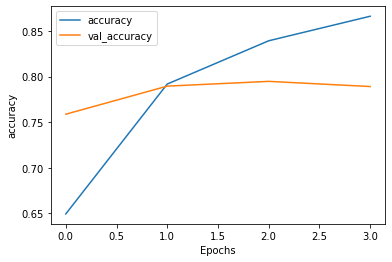

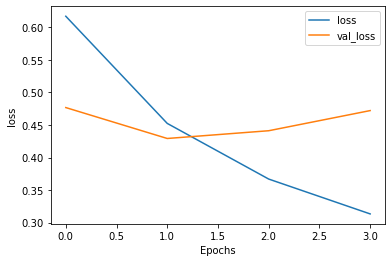

In [152]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")